# Order Forecasting for ERP System
In this project, we aim to build a forecasting model to predict future orders based on historical order data for an Enterprise Resource Planning (ERP) system. Accurate forecasting of order volumes is critical for businesses to optimize their inventory management, procurement, and production planning.

The forecasting model we will develop uses time series analysis to predict future orders based on the past data. We will apply a Seasonal ARIMA (SARIMA) model, which is an extension of the ARIMA (AutoRegressive Integrated Moving Average) model that accounts for both non-seasonal and seasonal components in time series data.

Firstly, we will install the necessary packages for statistical modeling (statsmodels) and ARIMA model building (pmdarima).

In [3]:
!pip install statsmodels
!pip install pmdarima

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as smapi
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import pmdarima as pm
import sys
import datetime
import os

Let's take a look on our data.

In [34]:
df = pd.read_csv('D:/Studies/Predictive models/Arima_new.csv')
print(df.head())

      Week  Orders
0  2019-08      85
1  2019-09      71
2  2019-10      66
3  2019-11      65
4  2019-12      65


In [36]:
df['Day'] = pd.to_datetime(df['Week'] + '-1', format='%Y-%U-%w')
print(df)

        Week  Orders        Day
0    2019-08      85 2019-02-25
1    2019-09      71 2019-03-04
2    2019-10      66 2019-03-11
3    2019-11      65 2019-03-18
4    2019-12      65 2019-03-25
..       ...     ...        ...
201  2022-51     133 2022-12-19
202  2022-52     126 2022-12-26
203   2023-1     120 2023-01-02
204   2023-2      94 2023-01-09
205   2023-3      92 2023-01-16

[206 rows x 3 columns]


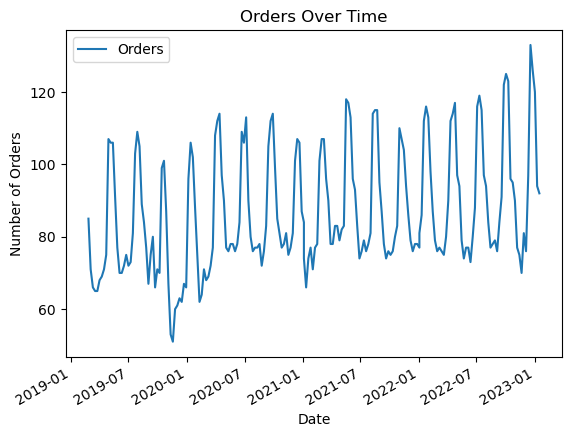

In [38]:
df.plot(x='Day', y='Orders', title="Orders Over Time")
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.show()

SARIMA is an extension of ARIMA that accounts for seasonality in the data. We use it when:

The data shows a repeating seasonal pattern (e.g., monthly sales data with yearly cycles).
A standard ARIMA model isn't enough because ARIMA only captures trends and not seasonality.
We want to remove seasonal effects and make better forecasts by adding seasonal autoregressive (SAR), seasonal differencing (D), and seasonal moving average (SMA) components.

In [41]:
# SARIMA model using auto_arima
model_sarima = pm.auto_arima(df['Orders'][0:170], 
                             start_p=0, start_q=0,           # Initial AR and MA terms
                             test='adf',                      # Use ADF test to determine d
                             max_p=5, max_q=5,                # Maximum p and q values
                             m=12,                            # Seasonal period (12 for monthly data with yearly seasonality)
                             d=None,                          # Let the model determine d
                             seasonal=True,                   # Enable seasonality (SARIMA)
                             start_P=0, start_Q=0,            # Initial seasonal AR and MA terms
                             D=1,                             # Seasonal differencing (D=1)
                             trace=True,                      # Show progress during fitting
                             error_action='ignore',           # Ignore errors
                             suppress_warnings=True,          # Suppress warnings
                             stepwise=True)                   # Efficient stepwise model search

print(model_sarima.summary())


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1092.915, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=932.478, Time=0.38 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.06 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1092.846, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=950.324, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=914.579, Time=0.68 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.72 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1043.574, Time=0.76 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=911.756, Time=1.26 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=930.792, Time=0.51 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.50 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.64 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=908.139, Time=1.68 sec
 ARIMA(3,0,0)(1,1,0)[12] intercept   : AIC=929.441

Our SARIMA(4,0,2)(2,1,1)₁₂ model effectively captures both trend and seasonality in the "Orders" dataset. It can be used for forecasting future order volumes while accounting for monthly variations over a yearly cycle.

#Data preprocessing
Before diving into modeling, it's important to get a sense of the underlying patterns in the dataset. In this step, I fill any missing values in the "Orders" column with the median of the dataset. This helps ensure that the model is not disrupted by gaps in the data.

I choose the median as a simple strategy for handling missing values, as it’s less sensitive to outliers compared to the mean.

Next, I plot the rolling mean and rolling standard deviation over a window of 12 periods (assuming monthly data), which helps me assess the stationarity of the time series.

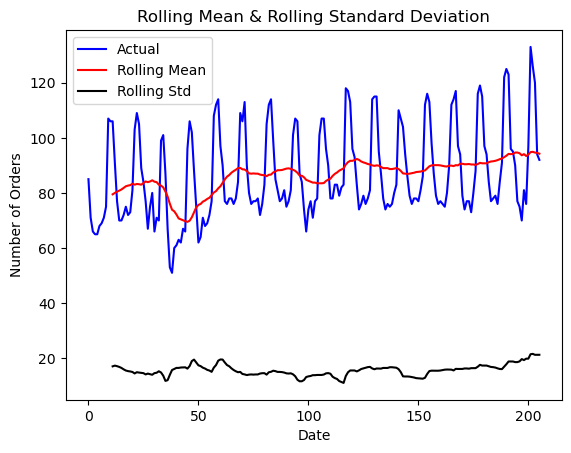

In [44]:
df['Orders'] = df['Orders'].fillna(df['Orders'].median())

rolling_mean = df['Orders'].rolling(window=12).mean()
rolling_std = df['Orders'].rolling(window=12).std()

plt.plot(df['Orders'], color='blue', label='Actual')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')

plt.legend(loc='best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Number of Orders')

plt.show()


The rolling mean shows a clear upward trend, suggesting that the number of orders is increasing over time. This implies there is a long-term upward trend in the data, which could be attributed to factors like growth in customer base or seasonality.
The rolling standard deviation appears to stay relatively low, but there are some noticeable increases at periodic intervals. This suggests that while the variability in the orders remains somewhat constant, there are bursts of increased volatility, likely due to seasonal demand or irregular spikes.
The low and stable rolling standard deviation indicates that the data’s variability doesn’t change drastically, which is somewhat reassuring when thinking about stationarity.
The actual order data shows clear seasonality, with periodic peaks and troughs that repeat over time. This cyclical pattern is consistent and implies that the orders exhibit seasonal fluctuations—perhaps due to seasonal promotions, holiday periods, or other periodic events.

# Checking Stationarity and Differencing
In this step, I am investigating whether the time series is stationary, which is a crucial assumption for many time series forecasting models, including ARIMA and SARIMA.

Stationarity means that the statistical properties of the time series, such as the mean and variance, do not change over time. If the data is non-stationary, we may need to apply differencing to make it stationary.
To check for stationarity, I have created two plots:

Original Time Series:

This plot shows the original order data without any transformations. The goal is to visually inspect for trends or seasonality.
First Difference:

The second plot shows the first difference of the data (df['Orders'].diff()), which calculates the difference between consecutive values. This transformation can help remove trends and make the series stationary if the original series has a trend.

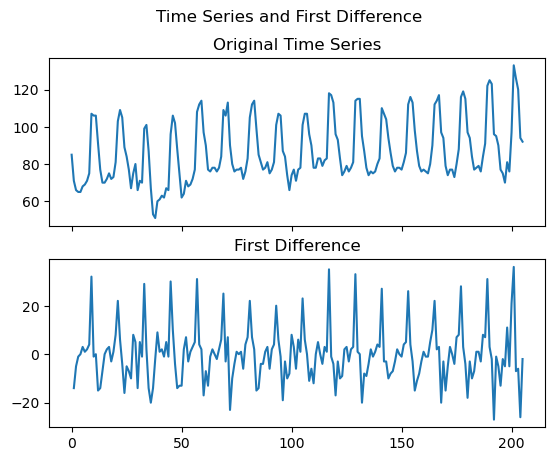

In [47]:
fig, axes = plt.subplots(2, 1, sharex=True)

axes[0].plot(df['Orders'])
axes[0].set_title('Original Time Series')

axes[1].plot(df['Orders'].diff())
axes[1].set_title('First Difference')

plt.suptitle('Time Series and First Difference')
plt.show()


Original Time Series: The data is non-stationary due to the trend and seasonality.

First Difference: The differenced data is more stationary, as the long-term trend has been removed, but seasonality still exists.

Given the seasonal behavior in the differenced data, we should proceed with building a SARIMA model (Seasonal ARIMA), which can account for both trend and seasonality in the time series.

The Augmented Dickey-Fuller (ADF) test is used to test the stationarity of a time series. Specifically, it checks whether a unit root is present, meaning if the time series is non-stationary. The null hypothesis of the ADF test is that the time series is non-stationary (has a unit root). If the p-value of the test is below a certain threshold (usually 0.05), we can reject the null hypothesis and conclude that the time series is stationary.

In [50]:
result = adfuller(df['Orders'])
print('-----------------------------')
print('Original Time Series')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

result = adfuller(df['Orders'][2:100])
print('-----------------------------')
print('Original Time Series (100 values)')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

result = adfuller(df['Orders'].diff().dropna())
print('-----------------------------')
print('1st Order Differencing')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

result = adfuller(df['Orders'][2:100].diff().dropna())
print('-----------------------------')
print('1st Order Differencing (100 values)')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

result = adfuller(df['Orders'].diff().diff().dropna())
print('-----------------------------')
print('2nd Order Differencing')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

result = adfuller(df['Orders'][2:100].diff().diff().dropna())
print('-----------------------------')
print('2nd Order Differencing (100 values)')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


-----------------------------
Original Time Series
ADF Statistic: -2.155607
p-value: 0.222750
-----------------------------
Original Time Series (100 values)
ADF Statistic: -1.822109
p-value: 0.369542
-----------------------------
1st Order Differencing
ADF Statistic: -3.734653
p-value: 0.003651
-----------------------------
1st Order Differencing (100 values)
ADF Statistic: -2.691395
p-value: 0.075539
-----------------------------
2nd Order Differencing
ADF Statistic: -13.345962
p-value: 0.000000
-----------------------------
2nd Order Differencing (100 values)
ADF Statistic: -7.632749
p-value: 0.000000


The original series is non-stationary (as indicated by the p-values greater than 0.05).
After first differencing, the series is still not perfectly stationary for the whole series, but it becomes stationary after the second differencing (as seen from the significant p-values).
In building a SARIMA model, you would likely use a second differencing, as the series has become stationary after two differences.

Let's check this with visualiation.

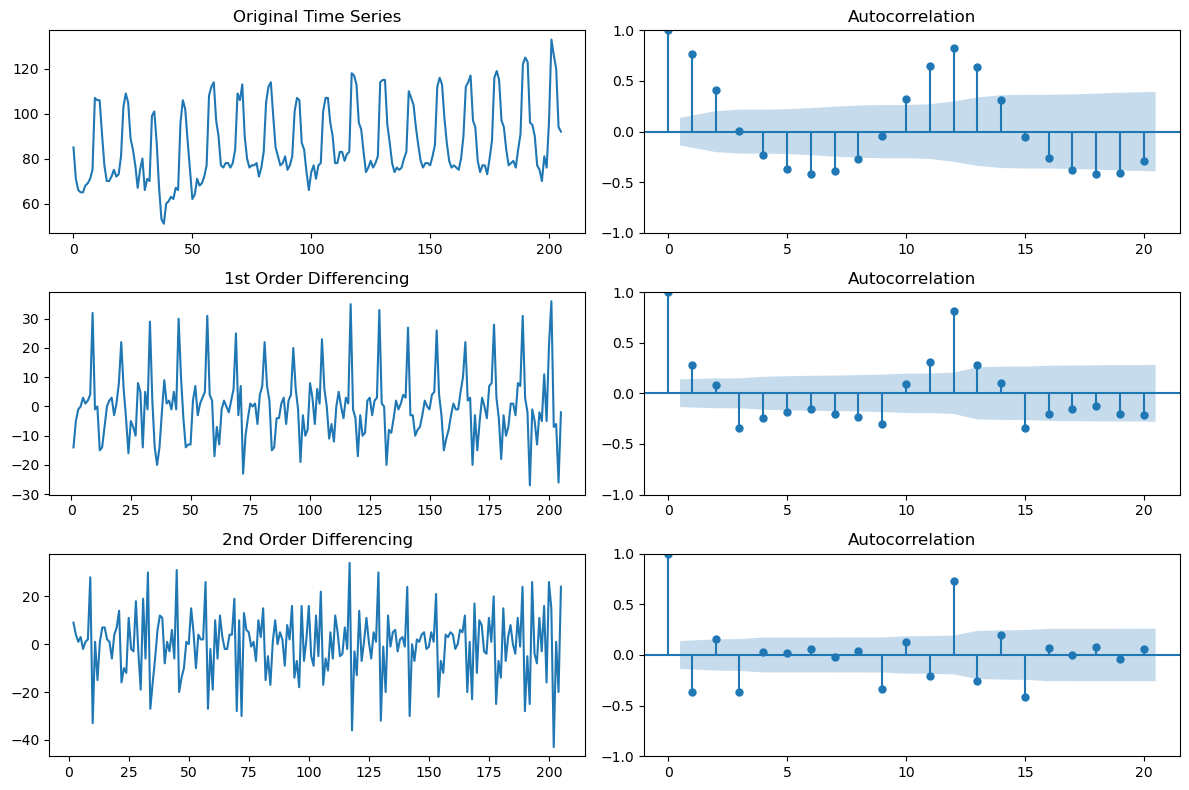

In [53]:
fig, axes = plt.subplots(3, 2, figsize=(12, 8))

axes[0, 0].plot(df['Orders'])
axes[0, 0].set_title('Original Time Series')

plot_acf(df['Orders'], ax=axes[0, 1], lags=20)

axes[1, 0].plot(df['Orders'].diff())
axes[1, 0].set_title('1st Order Differencing')

plot_acf(df['Orders'].diff().dropna(), ax=axes[1, 1], lags=20)

axes[2, 0].plot(df['Orders'].diff().diff())
axes[2, 0].set_title('2nd Order Differencing')

plot_acf(df['Orders'].diff().diff().dropna(), ax=axes[2, 1], lags=20)

fig.tight_layout()

plt.show()

The original time series exhibits trends and seasonality, which suggests it is non-stationary.
First differencing helps remove the linear trend but still leaves some seasonality.
Second differencing largely removes any remaining trend and seasonality, making the series more stationary.
The ACF plots confirm that differencing the series reduces autocorrelation at specific lags, indicating that the series is becoming stationary.

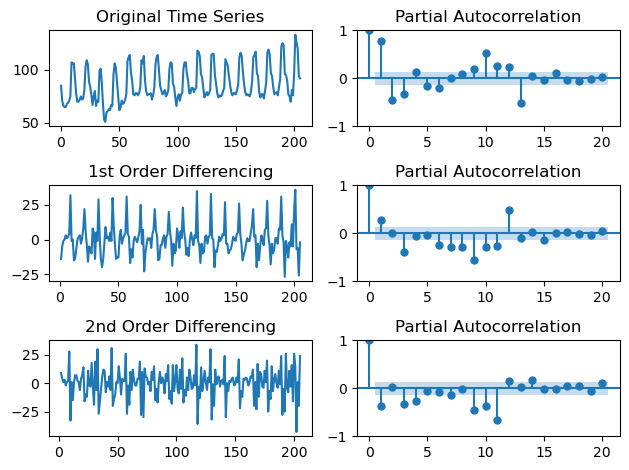

In [55]:
fig, axes = plt.subplots(3, 2, sharex=False)
axes[0, 0].plot(df.Orders); axes[0, 0].set_title('Original Time Series')
plot_pacf(df.Orders, ax=axes[0, 1], lags=20); axes[0, 1]

# 1st Differencing
axes[1, 0].plot(df.Orders.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_pacf(df.Orders.diff().dropna(), ax=axes[1, 1], lags=20)

# 2nd Differencing
axes[2, 0].plot(df.Orders.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_pacf(df.Orders.diff().diff().dropna(), ax=axes[2, 1], lags=20)

fig.tight_layout()
plt.show()


In [66]:
model = SARIMAX(df['Orders'][0:150], order=(4, 0, 2), seasonal_order=(2, 1, 1, 12))
result = model.fit()

print(result.summary())

C:\Users\marco\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\marco\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\marco\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                               Orders   No. Observations:                  150
Model:             SARIMAX(4, 0, 2)x(2, 1, [1], 12)   Log Likelihood                -383.600
Date:                              Mon, 17 Mar 2025   AIC                            787.200
Time:                                      21:30:21   BIC                            816.472
Sample:                                           0   HQIC                           799.095
                                              - 150                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3109      0.133     -2.337      0.019      -0.572      -0.050
ar.L2          0.03

Significant terms: The significant coefficients include ar.L1, ar.L3, ma.L1, ma.L2, and ma.S.L12, which indicate important relationships between observations and errors at specific lags.
Non-significant terms: Some AR and seasonal AR terms (ar.L2, ar.L4, ar.S.L12, ar.S.L24) are not statistically significant, suggesting that they don’t contribute much to the model.
Good model fit: The diagnostic tests suggest that the residuals are well-behaved (no autocorrelation, normal distribution), which indicates a good fit.
AIC and BIC: The model's AIC and BIC values are reasonable, but further improvement can be achieved by tuning the model parameters or adding more observations.

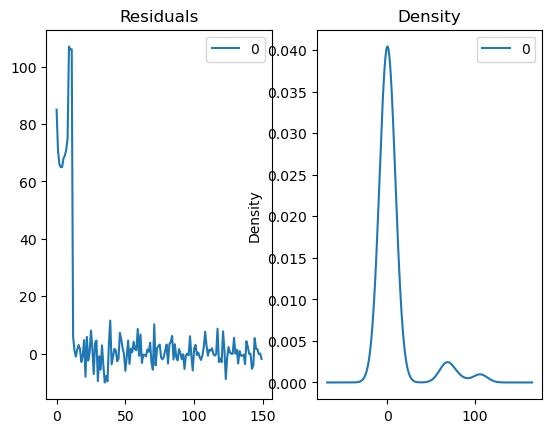

In [57]:
# Plot residual errors
residuals = pd.DataFrame(result.resid)
fig, ax = plt.subplots(1, 2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

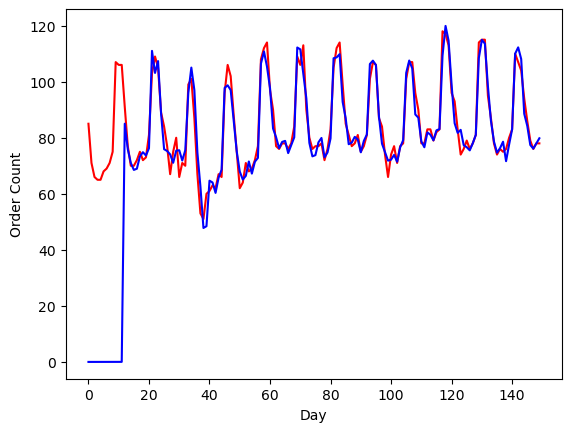

In [69]:
plt.plot(df.Orders[0:150], 'r')
plt.plot(result.predict(dynamic=False)[0:150], 'b')
plt.xlabel('Day')
plt.ylabel('Order Count')
plt.show()

In [71]:
# Split the data into training and testing sets
train = df.Orders[0:131]
test = df.Orders[130:140]

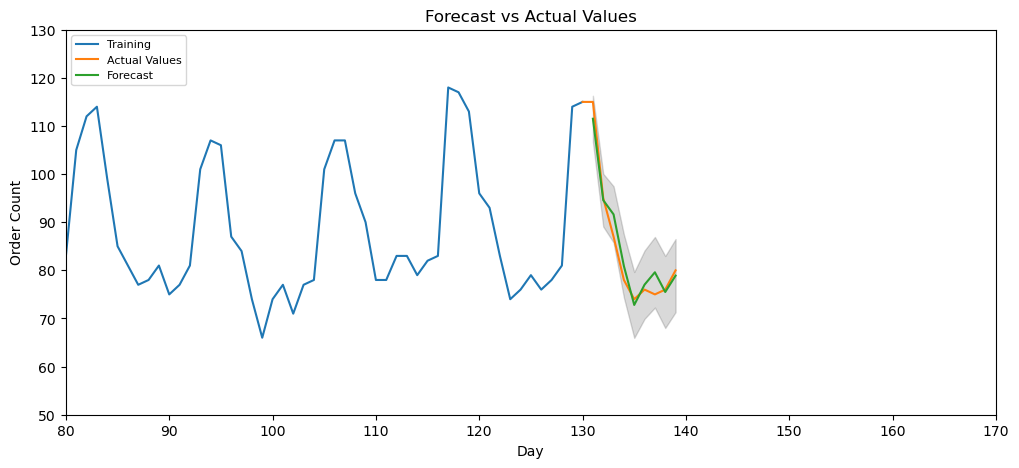

In [79]:
import warnings

model = SARIMAX(train, 
                order=(4, 0, 2),          # ARIMA order (p, d, q)
                seasonal_order=(2, 1, 1, 12),  # Seasonal order (P, D, Q, s)
                enforce_stationarity=False, 
                enforce_invertibility=False)

fitted = model.fit(disp=-1)

# Forecast
forecast = fitted.forecast(steps=len(test))

# Confidence intervals
conf = fitted.get_forecast(steps=len(test)).conf_int(alpha=0.2)
fc_series = pd.Series(forecast, index=test.index)
lower_series = pd.Series(conf.iloc[:, 0], index=test.index)
upper_series = pd.Series(conf.iloc[:, 1], index=test.index)

# Plot the results
plt.figure(figsize=(12, 5), dpi=100)
plt.axis([80, 170, 50, 130])
plt.plot(train, label='Training')
plt.plot(test, label='Actual Values')
plt.plot(fc_series, label='Forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.xlabel('Day')
plt.ylabel('Order Count')
plt.title('Forecast vs Actual Values')
plt.legend(loc='upper left', fontsize=8)
plt.show()